<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/NADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

fatal: destination path 'nn_hallucinations' already exists and is not an empty directory.


In [0]:
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions 
from torch import nn
from torch import optim
from torch.utils import data
import torchvision
from torchvision import transforms
from torchvision import datasets

In [0]:
BATCH_SIZE = 512
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.view(-1),  # Flatten.
    # NOTE(eugenhotaj): The binarization transform randomly samples a new digit
    # each time it is called. This means that each example will be slightly 
    # different on each epoch, acting as a form of data augmentation. This (
    # along with a few other tweaks) leads to lower loss than reported in the
    # original NADE paper.
    lambda x: distributions.Bernoulli(probs=x).sample()])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE*2)

In [0]:
class NADE(nn.Module):
  """Implementation of the Neural Autoregressive Distribution Estimator (NADE).

  NADE can be viewed as a one hidden layer autoencoder trained with a "language
  model criterion", i.e. trained to approximate p(x_i | x_{j<i}). The 
  connectivity pattern of NADE is specialized to enable this training criterion.
  
  For full details, see the paper by Larochelle & Murray (2011).
  """

  def __init__(self, input_dim, hidden_dim):
    """Initializes a new NADE instance.

    Args:
      input_dim: The dimension of the input.
      hidden_dim: The dimmension of the hidden layer. NADE only supports one
        hidden layer.
    """
    super().__init__()
    self._input_dim = input_dim
    self._hidden_dim = hidden_dim
    self.params = nn.ParameterDict({
      'in_W': nn.Parameter(torch.zeros(self._hidden_dim, self._input_dim)),
      'in_b': nn.Parameter(torch.zeros(self._hidden_dim,)),
      'h_W': nn.Parameter(torch.zeros(self._input_dim, self._hidden_dim)),
      'h_b': nn.Parameter(torch.zeros(self._input_dim,)),
    })
    nn.init.kaiming_normal_(self.params['in_W'])
    nn.init.kaiming_normal_(self.params['h_W'])

  def _forward(self, x):
    """Computes a forward pass and samples a new output.
    
    Returns:
      (p_hat, x_hat) where p_hat is the probability distribution over dimensions
      and x_hat *might* be sampled from p_hat. See the 'sample' method for
      specifics of sampling.
    """
    in_W, in_b = self.params['in_W'], self.params['in_b']
    h_W, h_b = self.params['h_W'], self.params['h_b']
    batch_size = 1 if x is None else x.shape[0] 

    p_hat = []
    x_hat = []
    # Only the bias is used to compute the first hidden unit so we must 
    # replicate it to account for the batch size.
    a = in_b.expand(batch_size, -1)
    for i in range(self._input_dim):
      h = torch.relu(a)
      p_i = torch.sigmoid(h_b[i:i+1] + h @ h_W[i:i+1, :].t())
      p_hat.append(p_i)

      # Sample 'x' at dimension 'i' if it is not given.
      x_i = x[:, i:i+1]
      x_i = torch.where(x_i < 0, 
                        distributions.Bernoulli(probs=p_i).sample(),
                        x_i)
      x_hat.append(x_i)

      # We do not need to add in_b[i:i+1] when computing the other hidden units
      # since it was already added when computing the first hidden unit. 
      a = a + x_i @ in_W[:, i:i+1].t()
    return torch.cat(p_hat, dim=1), torch.cat(x_hat, dim=1) if x_hat else []

  def forward(self, x):
    """Computes a forward pass."""
    return self._forward(x)[0]

  def sample(self, conditioned_on=None):
    """Samples a new image.
    
    Args:
      conditioned_on: An (optional) image to condition samples on. Only 
        dimensions with values < 0 will be sampled. For example, if 
        conditioned_on[i] = -1, then output[i] will be sampled conditioned on
        dimensions j < i. If 'None', an unconditional sample will be generated.
    """
    with torch.no_grad():
      if conditioned_on is None:
        device = next(self.parameters()).device
        conditioned_on = (torch.ones((1, self._input_dim)) * -1).to(device)
      return self._forward(conditioned_on)[1]

In [37]:
INPUT_SIZE = 784
HIDDEN_SIZE = 500
N_EPOCHS = 50

model = NADE(INPUT_SIZE, HIDDEN_SIZE).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')
loss_fn = lambda x, y, preds: bce_loss_fn(preds, x).sum(dim=1).mean()

train_losses, eval_losses = colab_utils.train_andor_evaluate(
    model,  
    loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    eval_loader=test_loader,
    n_epochs=N_EPOCHS,
    device=colab_utils.get_device())

[1]: train_loss=214.47838545735678 eval_loss=123.40267498779296
[2]: train_loss=113.16199818115234 eval_loss=104.80730128173828
[3]: train_loss=102.54870853271484 eval_loss=99.14672703857421
[4]: train_loss=98.54365208333333 eval_loss=96.43514365234375
[5]: train_loss=96.29144740397136 eval_loss=94.6224109741211
[6]: train_loss=94.8628626139323 eval_loss=93.61016378173828
[7]: train_loss=93.82354176839193 eval_loss=92.66889282226562
[8]: train_loss=93.05385642903646 eval_loss=92.15790789794922
[9]: train_loss=92.31129790445964 eval_loss=91.4070034790039
[10]: train_loss=91.7283138712565 eval_loss=91.05392630615235
[11]: train_loss=91.29113751627604 eval_loss=90.58937724609375
[12]: train_loss=90.843610550944 eval_loss=90.17885793457032
[13]: train_loss=90.39923013509114 eval_loss=89.90242333984375
[14]: train_loss=90.08089680989583 eval_loss=89.57236571044922
[15]: train_loss=89.78214048258464 eval_loss=89.21473328857422
[16]: train_loss=89.4836215209961 eval_loss=88.95697889404296
[17

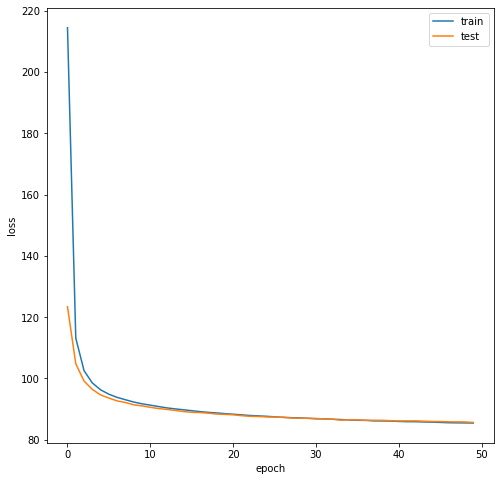

In [38]:
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))

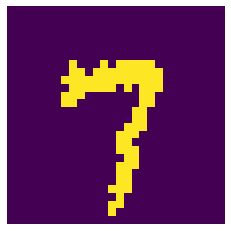

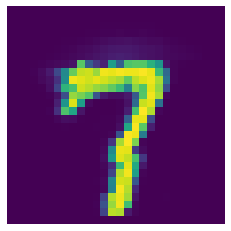

In [40]:
show_random(model, test_loader.dataset)

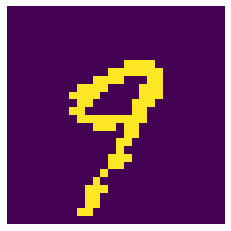

In [42]:
colab_utils.imshow(model.sample().reshape(28, 28))

In [0]:
def conditional_sample_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img[0, 300:600] = -1
  colab_utils.imshow(img.reshape(28, 28))
  plt.show()
  print("Conditional Samples:")
  for i in range(5):
    img_hat = model.sample(img)
    colab_utils.imshow(img_hat.reshape(28, 28))

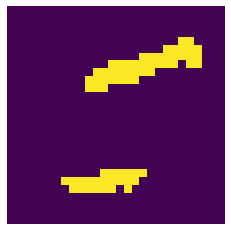

Conditional Samples:


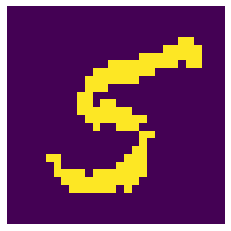

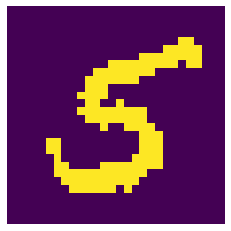

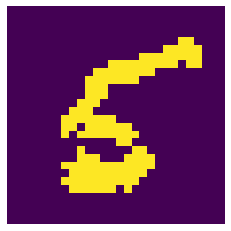

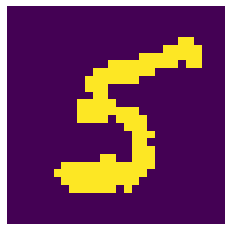

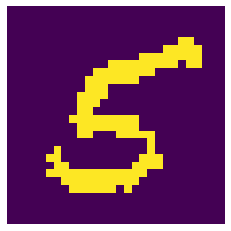

In [44]:
conditional_sample_random(model, test_loader.dataset)